In [1]:
import shap
import cv2
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
import copy
%matplotlib inline
import skimage.segmentation
from sklearn.linear_model import LinearRegression
from skimage.color import gray2rgb
import os
from PIL import Image
import joblib

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage.color import rgb2gray
import matplotlib.pylab as plt

In [3]:
import imageio
import imgaug as ia
import imgaug.augmenters as iaa
import ipyplot

input_img = imageio.imread('xai_thyroid/Data/datapre/108_1.jpg')
rot1 = iaa.Affine(rotate=(-90))
input_rot1 = rot1.augment_image(input_img)
# images_list=[input_img, input_rot1]
# labels = ['Original', 'Rotated Image']
# ipyplot.plot_images(images_list,labels=labels,img_width=180)

In [4]:

# read by default 1st sheet of an excel file
# df = pd.read_excel('xai_thyroid/Data/labels.xlsx', header=0)
# df.to_csv('xai_thyroid/Data/labels.csv', index=False)
dataframe = pd.read_csv("xai_thyroid/Data/labels.csv", encoding='utf-8')
dataframe = dataframe[:480]
# print(dataframe)

dataset = []
for i in range(len(dataframe)):
    if dataframe["Cla1"][i]==0:
        continue
    row_data = []
    
    for row in dataframe:
        row_data.append(dataframe[row][i])
    dataset.append(row_data)

dataset

[['2_1', 1, '2'],
 ['3_1', 2, '4a'],
 ['4_1', 2, '4a'],
 ['5_1', 2, '5'],
 ['6_1', 2, '4b'],
 ['7_1', 2, '4a'],
 ['8_1', 2, '4c'],
 ['9_1', 2, '4b'],
 ['10_1', 2, '4b'],
 ['11_1', 2, '5'],
 ['12_1', 2, '4a'],
 ['13_1', 2, '4a'],
 ['14_1', 1, '2'],
 ['15_1', 2, '4c'],
 ['16_1', 1, '3'],
 ['17_1', 1, '2'],
 ['18_1', 2, '4a'],
 ['19_1', 2, '5'],
 ['20_1', 2, '4b'],
 ['21_1', 2, '4a'],
 ['22_1', 1, '2'],
 ['23_1', 2, '4a'],
 ['24_1', 2, '4b'],
 ['25_1', 1, '3'],
 ['26_1', 2, '4a'],
 ['27_1', 2, '4b'],
 ['28_1', 2, '4b'],
 ['29_1', 2, '5'],
 ['30_1', 2, '4c'],
 ['31_1', 1, '3'],
 ['32_1', 2, '4a'],
 ['33_1', 2, '4a'],
 ['34_1', 2, '4c'],
 ['35_1', 2, '4b'],
 ['36_1', 2, '5'],
 ['38_1', 2, '4b'],
 ['39_1', 2, '4a'],
 ['40_1', 2, '4a'],
 ['41_1', 2, '4b'],
 ['42_1', 2, '4b'],
 ['43_1', 2, '4c'],
 ['44_1', 2, '4a'],
 ['45_1', 2, '4b'],
 ['46_1', 2, '5'],
 ['47_1', 2, '4a'],
 ['48_1', 2, '4b'],
 ['49_1', 2, '4a'],
 ['50_1', 2, '4a'],
 ['51_1', 1, '2'],
 ['52_1', 2, '4a'],
 ['53_1', 2, '4c'],
 [

In [5]:
import cv2
import numpy as np
from scipy.fftpack import dct

def pb_dct(image, block_size=8, threshold=0.5):
    # Ensure the image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Pad the image to a multiple of the block size
    height, width = image.shape
    pad_height = ((height + block_size - 1) // block_size) * block_size
    pad_width = ((width + block_size - 1) // block_size) * block_size
    padded_image = np.zeros((pad_height, pad_width))
    padded_image[:height, :width] = image
    
    # Initialize the PB-DCT coefficients matrix
    pb_dct_coeffs = np.zeros((pad_height, pad_width))
    
    # Perform PB-DCT on blocks
    for y in range(0, pad_height, block_size):
        for x in range(0, pad_width, block_size):
            block = padded_image[y:y+block_size, x:x+block_size]
            dct_block = dct(dct(block, axis=0, norm='ortho'), axis=1, norm='ortho')
            
            # Apply polar binarization to the DCT coefficients
            pb_dct_block = polar_binarization(dct_block, threshold)
            
            pb_dct_coeffs[y:y+block_size, x:x+block_size] = pb_dct_block
    
    return pb_dct_coeffs

def polar_binarization(block, threshold=0.5):
    # Calculate the polar angle
    angle = np.arctan2(block, block[::-1])
    
    # Binarize based on the threshold
    binarized_block = np.where(np.abs(angle) >= threshold, 1, 0)
    
    return binarized_block

path = 'xai_thyroid/Data/datapre/' + "3_1" + '.jpg'
image = imread(path)
block_size = 8
threshold = 0.5
pb_dct_coeffs = pb_dct(image, block_size, threshold)
print(pb_dct_coeffs)

[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 0. 1.]
 [0. 1. 1. ... 0. 1. 1.]
 [0. 1. 1. ... 0. 1. 1.]]


In [6]:
import os
import time
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.fftpack import dct

def features_of_single_image(I):

    block_size = 8
    threshold = 0.5
    pb_dct_coeffs = pb_dct(I, block_size, threshold)
    flattened = pb_dct_coeffs.ravel()  
    return flattened

path = 'xai_thyroid/Data/datapre/' + "108_1" + '.jpg'
img = imread(path)
img=gray2rgb(img)
print(len(features_of_single_image(img)))

92416


In [7]:
path = 'xai_thyroid/Data/datapre/' + "108_1" + '.jpg'
img = imread(path)
img=gray2rgb(img)
print(img)
features_of_single_image(img)

[[[  0   0   0]
  [ 10  10  10]
  [189 189 189]
  ...
  [  2   2   2]
  [  1   1   1]
  [  0   0   0]]

 [[  0   0   0]
  [115 115 115]
  [253 253 253]
  ...
  [  3   3   3]
  [ 10  10  10]
  [ 12  12  12]]

 [[ 62  62  62]
  [255 255 255]
  [255 255 255]
  ...
  [119 119 119]
  [108 108 108]
  [155 155 155]]

 ...

 [[  6   6   6]
  [  8   8   8]
  [ 55  55  55]
  ...
  [110 110 110]
  [125 125 125]
  [144 144 144]]

 [[  0   0   0]
  [  0   0   0]
  [ 47  47  47]
  ...
  [ 87  87  87]
  [ 97  97  97]
  [109 109 109]]

 [[  9   9   9]
  [  6   6   6]
  [ 59  59  59]
  ...
  [116 116 116]
  [106 106 106]
  [105 105 105]]]


array([1., 1., 1., ..., 0., 0., 1.])

In [8]:
path = 'xai_thyroid/Data/datapre/' + "3_1" + '.jpg'
img = imread(path)
img=gray2rgb(img)
print(img)
features_of_single_image(img)

[[[ 74  74  74]
  [139 139 139]
  [ 10  10  10]
  ...
  [  0   0   0]
  [  0   0   0]
  [  3   3   3]]

 [[219 219 219]
  [242 242 242]
  [133 133 133]
  ...
  [115 115 115]
  [106 106 106]
  [ 95  95  95]]

 [[255 255 255]
  [255 255 255]
  [238 238 238]
  ...
  [203 203 203]
  [199 199 199]
  [183 183 183]]

 ...

 [[ 30  30  30]
  [171 171 171]
  [174 174 174]
  ...
  [ 62  62  62]
  [ 51  51  51]
  [ 39  39  39]]

 [[ 29  29  29]
  [147 147 147]
  [154 154 154]
  ...
  [ 22  22  22]
  [ 15  15  15]
  [  8   8   8]]

 [[  0   0   0]
  [ 75  75  75]
  [ 71  71  71]
  ...
  [ 39  39  39]
  [ 32  32  32]
  [ 24  24  24]]]


array([1., 1., 1., ..., 0., 1., 1.])

In [9]:
X = []
Y = []
count = 0
for row in dataset:
    path = 'xai_thyroid/Data/datapre/' + row[0] + '.jpg'
    img = imread(path)
    img=gray2rgb(img)
    X.append(features_of_single_image(img))
    Y.append(row[1])
        
    count=count+1
    print(count)
    
print(len(X))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [10]:
X[0]

array([1., 1., 1., ..., 1., 1., 1.])

In [11]:
from imblearn.over_sampling import SMOTE
smt=SMOTE()
X_n,Y_n=smt.fit_resample(X,Y)

In [12]:
print(len(X_n))
print(len(Y_n))
X=X_n
Y=Y_n

576
576


In [13]:
x1=x2=0
for x in Y_n:
    if(x==1):
        x1=x1+1
    if(x==2):
        x2=x2+1
print(x1," ",x2)

288   288


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y ,
                                   random_state=104, 
                                   test_size=0.2, 
                                   shuffle=True)
print(len(X_train))
print(len(X_test))

460
116


# Applying SVM Model

In [16]:
from sklearn.svm import SVC  
clf = SVC(kernel='linear', probability=True) 
  
# fitting x samples and y classes 
clf.fit(X_train,Y_train) 

SVC(kernel='linear', probability=True)

In [17]:
count =0
for i in range(len(X_test)):
    ans=clf.predict([X_test[i]])
    if(ans[0]!=Y_test[i]):
        print(i, " ", ans[0], " ", Y_test[i])
        count += 1
count

60   2   1


1

In [18]:
print(len(X[0]))

92416


# LIME Model

In [19]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.svm import SVC

In [20]:
def prediction_function(images):
    result = []
    for image in images:
        features = features_of_single_image(image)
        predictions = clf.predict_proba([features])
        result.append(predictions[0])
    result = np.array(result)
    return result

images = ['50_1']
filename = images[0]
pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
image_to_explain = matplotlib.image.imread(pathname)
image_to_explain = gray2rgb(image_to_explain)
results_of_image = prediction_function(np.array([image_to_explain,image_to_explain]))
results_of_image

array([[1.45657732e-06, 9.99998543e-01],
       [1.45657732e-06, 9.99998543e-01]])

In [21]:
explainer = lime_image.LimeImageExplainer()

# Choose an image to explain (replace with your image)
images = ['50_1']
filename = images[0]
pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
image_to_explain = matplotlib.image.imread(pathname)
image_to_explain = gray2rgb(image_to_explain)

# Explain the model's prediction for the chosen image
explanation = explainer.explain_instance(
    image_to_explain,
    classifier_fn=prediction_function,
#     top_labels=1,  # Number of top labels to explain (adjust as needed)
#     hide_color=0,  # Use 0 for black and white images
    num_samples=1000,  # Number of random samples to generate
#     segmentation_fn=None,  # Segmentation function (or use default)
)

  0%|          | 0/1000 [00:00<?, ?it/s]

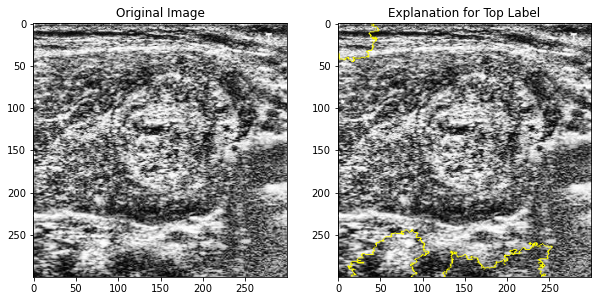

In [24]:
# Display the original image and the explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_to_explain)
plt.title('Original Image')

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    hide_rest=False,
)
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title('Explanation for Top Label')
plt.show()

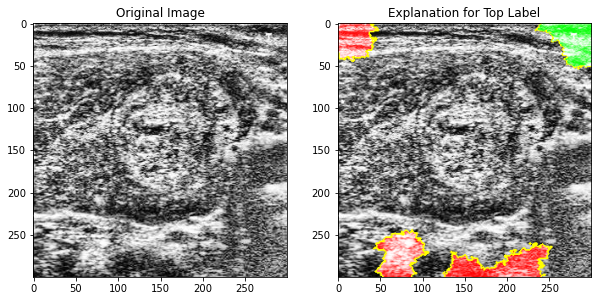

In [25]:

# Display the original image and the explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_to_explain)
plt.title('Original Image')

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    num_features=5,
    hide_rest=False,
)
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title('Explanation for Top Label')
plt.show()

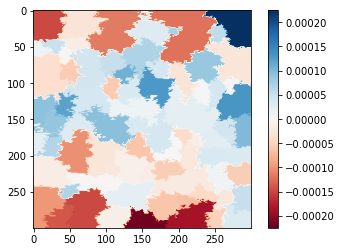

In [26]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [27]:
import pickle

# Assuming 'explanation' is your Lime explanation object
  # Your Lime explanation object

# Specify the file path where you want to save the explanation
file_path = "lime_explanation.pkl"

# Save the explanation to a file
with open(file_path, "wb") as file:
    pickle.dump(explanation, file)

print(f"Lime explanation saved to {file_path}")


Lime explanation saved to lime_explanation.pkl


In [28]:
import pickle

# Specify the file path where the Lime explanation is saved
file_path = "lime_explanation.pkl"  # Replace with your file path

# Load the Lime explanation from the file
with open(file_path, "rb") as file:
    var = pickle.load(file)


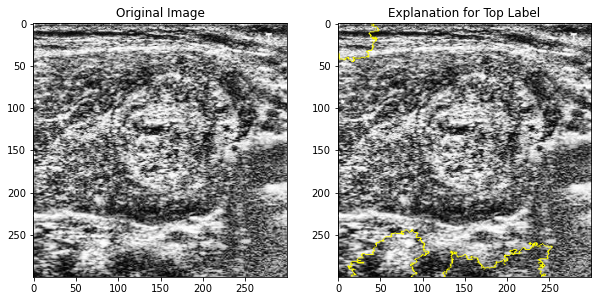

In [29]:
# Display the original image and the explanation
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_to_explain)
plt.title('Original Image')

temp, mask = var.get_image_and_mask(
    var.top_labels[0],
    positive_only=False,
    negative_only=True,
    hide_rest=False,
)
plt.subplot(1, 2, 2)
plt.imshow(mark_boundaries(temp, mask))
plt.title('Explanation for Top Label')
plt.show()

# Generating Results for All Images

In [30]:
import pickle

explainer = lime_image.LimeImageExplainer()

In [1]:
X = []
Y = []
count = 0
for row in dataset:
    count=count+1
    print(count)
    print(row[0])
    if count<160:
        continue
    
    filename=row[0]
    pathname = r'C:/Users/tayal/Desktop/Projects/BTP Project/survey XAI/proj/proj/xai_thyroid/Data/datapre/' + filename + '.jpg'
    image_to_explain = matplotlib.image.imread(pathname)
    image_to_explain = gray2rgb(image_to_explain)


    explanation = explainer.explain_instance(
        image_to_explain,
        classifier_fn=prediction_function,
        num_samples=1000,
    )
    
    file_path = "PB-DCT-SVM-LIME Model Results/" + str(row[1]) + "/" + filename + '.pkl'
    # Save the explanation to a file
    with open(file_path, "wb") as file:
        pickle.dump(explanation, file)
    print(f"Lime explanation saved to {file_path}")
    
    with open(file_path, "rb") as file:
        var = pickle.load(file)
    explanation = var


    # Display the original image and the explanation
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_to_explain)
    plt.title('Original Image')

    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=100,
        hide_rest=False,
    )
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp, mask))
    plt.title('Explanation for Top Label')
    plt.show()


    #Select the same class explained on the figures above.
    ind =  explanation.top_labels[0]
    #Map each explanation weight to the corresponding superpixel
    dict_heatmap = dict(explanation.local_exp[ind])
    heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
    #Plot. The visualization makes more sense if a symmetrical colorbar is used.
    plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
    plt.colorbar()
    

NameError: name 'dataset' is not defined